In [11]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2768), started 12:58:16 ago. (Use '!kill 2768' to kill it.)

In [163]:
import datetime, os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model

import pandas as pd
from PIL import Image
from keras.utils import load_img
from keras.utils import img_to_array
# I don't think we need this function
# from keras.utils import array_to_img

In [13]:
training_csv = pd.read_csv('fairface_label_train.csv')
training_csv = training_csv.iloc[1:200]
training_csv = training_csv.reset_index()
training_images = []
for index, row in training_csv.iterrows():
    image = Image.open(row['file']).convert("L") # load_img(row['file'], color_mode="grayscale", target_size=(32,32))
    data = np.asarray(image)
    training_images.append(data)
#     print(f"Loaded image: {type(image)}")
#     print(f"image #{index} file name: {row['file']}")
#     print(f"image #{index} format: {image.format}")
#     print(f"image #{index} size: {image.size}")
    image_array = np.asarray(image) # img_to_array(image) (using the keras methods gives float32 type instead of uint8, not sure which we need)
#     print(f"Numpy array: {type(image_array)}")
#     print(f"image array #{index} type: {image_array.dtype}")
#     print(f"image array #{index} shape: {image_array.shape}")
testing_csv = pd.read_csv('fairface_label_val.csv')
testing_csv = testing_csv.iloc[1:50]
testing_csv = testing_csv.reset_index()
testing_images = []
for index, row in testing_csv.iterrows():
    image = Image.open(row['file']).convert("L")
    data = np.asarray(image)
    testing_images.append(data)

In [14]:
# Min-Max Scale the training_images based on their min and max values (per image, not just scaled from 0 to 255)
#                                                at least according to the google chat  ^^^
temp = []
for i in training_images:
    mymaxes = []
    mymins = []
    for j in i:
        mymaxes.append(max(j))
        mymins.append(min(j))
    mymax = max(mymaxes)
    mymin = min(mymins)
    tempcol = []
    for j in i:
        temprow = []
        for k in j:
            temprow.append((k - mymin) / (mymax - mymin))
        tempcol.append(temprow)
    temp.append(tempcol)
training_images = temp
training_images = np.array(training_images)
# Scale the testing_images the same way
temp = []
for i in testing_images:
    mymaxes = []
    mymins = []
    for j in i:
        mymaxes.append(max(j))
        mymins.append(min(j))
    mymax = max(mymaxes)
    mymin = min(mymins)
    tempcol = []
    for j in i:
        temprow = []
        for k in j:
            temprow.append((k - mymin) / (mymax - mymin))
        tempcol.append(temprow)
    temp.append(tempcol)
testing_images = temp
testing_images = np.array(testing_images)

In [15]:
#also set up other vectors for training/validation
#Gender
genders = training_csv["gender"]
gens = []
for i in range(len(genders)):
    genset = np.zeros(2)
    if "Female" in genders[i]:
        genset[0] = 1
    else:
        genset[1] = 1
    gens.append(genset)
genders = gens.copy()

gendersVal = testing_csv["gender"]
gens = []
for i in range(len(gendersVal)):
    genset = np.zeros(2)
    if "Female" in gendersVal[i]:
        genset[0] = 1
    else:
        genset[1] = 1
    gens.append(genset)
gendersVal = gens.copy()

#Race
racs = []
races = training_csv["race"]
for i in races:
    if i not in racs:
        racs.append(i)
tempRaces = []
for i in range(len(races)):
    racset = np.zeros(len(racs))
    racset[racs.index(races[i])] = 1
    tempRaces.append(racset)
races = tempRaces.copy()

racesVal = testing_csv["race"]
tempRaces = []
for i in range(len(racesVal)):
    racset = np.zeros(len(racs))
    racset[racs.index(racesVal[i])] = 1
    tempRaces.append(racset)
racesVal = tempRaces.copy()
numRaces = len(racs)

genders = np.array(genders)
gendersVal = np.array(gendersVal)
races = np.array(races)
racesVal = np.array(racesVal)

## Task 1: Fully Connected Neural Network
##### 1. Build a feed forward neural network with the following specs (for 2 separate tasks)
###### a. Hidden layer 1: 1024 neurons with tanh activation function in each 
###### b. Hidden layer 2: 512 neurons with sigmoid activation function in each 
###### c. Hidden layer 3: 100 neurons with reLu
###### d. Output layer: n (depending on the task) representing n classes, using softmax activation

In [16]:
# fmodel = Sequential()
# fmodel.add(keras.Input(shape=(32,32,1)))
# fmodel.add(layers.Dense(1024, activation='tanh'))
# fmodel.add(layers.Dense(512, activation='sigmoid'))
# fmodel.add(layers.Dense(100, activation='relu'))
# # find n for the task, add this layer
# fmodel.add(layers.Dense(n, activation='softmax'))

### Task 1, Classification Task A: Gender

In [17]:
# classify gender
famodel = Sequential()
famodel.add(keras.Input(shape=(32,32,1)))
famodel.add(layers.Flatten())
famodel.add(layers.Dense(1024, activation='tanh'))
famodel.add(layers.Dense(512, activation='sigmoid'))
famodel.add(layers.Dense(100, activation='relu'))
n = 2
famodel.add(layers.Dense(n, activation='softmax'))
# min max already taken care of, use mini-batch gradient descent to optimize categorical cross entropy, 
# record and graph each epoch's epoch-accuracy and epoch-loss for both the training and validation set
# also graph the confusion matrix
opt = keras.optimizers.SGD(learning_rate=0.01)
famodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task1Genders"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

famodel.fit(training_images, genders, epochs=50, batch_size=10, validation_data=(testing_images, gendersVal), callbacks=[tensorboard_callback])

Epoch 1/50
20/20 [==============================] - 1s 21ms/step - loss: 0.7063 - accuracy: 0.5226 - val_loss: 0.6956 - val_accuracy: 0.5306
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 0.6948 - accuracy: 0.5327 - val_loss: 0.6926 - val_accuracy: 0.5306
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.7198 - accuracy: 0.4824 - val_loss: 0.6946 - val_accuracy: 0.5306
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 0.6973 - accuracy: 0.5025 - val_loss: 0.7237 - val_accuracy: 0.4898
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 0.6985 - accuracy: 0.5377 - val_loss: 0.7216 - val_accuracy: 0.4898
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 0.6914 - accuracy: 0.5176 - val_loss: 0.6895 - val_accuracy: 0.5714
Epoch 7/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6871 - accuracy: 0.5628 - val_loss: 0.6845 - val_accuracy: 0.5510
Epoch 8/50
20

### Task 1, Classification Task B: Race

In [18]:
# classify race
fbmodel = Sequential()
fbmodel.add(keras.Input(shape=(32,32,1)))
fbmodel.add(layers.Flatten())
fbmodel.add(layers.Dense(1024, activation='tanh'))
fbmodel.add(layers.Dense(512, activation='sigmoid'))
fbmodel.add(layers.Dense(100, activation='relu'))
# find n for the task, add this layer
n = numRaces
fbmodel.add(layers.Dense(n, activation='softmax'))
# min max already taken care of, use mini-batch gradient descent to optimize categorical cross entropy, 
# record and graph each epoch's epoch-accuracy and epoch-loss for both the training and validation set
# also graph the confusion matrix
opt = keras.optimizers.SGD(learning_rate=0.01)
fbmodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task1Races"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

fbmodel.fit(training_images, races, epochs=100, batch_size=10, validation_data=(testing_images, racesVal), callbacks=[tensorboard_callback])
# if you have the setup and training in different blocks in the notebook, 
# you can accidentally train it multiple times, compounding how well it gets trained, 
# so keep the training in the same block as the setup

Epoch 1/100
20/20 [==============================] - 1s 28ms/step - loss: 1.9509 - accuracy: 0.2010 - val_loss: 1.9813 - val_accuracy: 0.2041
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 1.9437 - accuracy: 0.1960 - val_loss: 1.9313 - val_accuracy: 0.2041
Epoch 3/100
20/20 [==============================] - 0s 25ms/step - loss: 1.9265 - accuracy: 0.2211 - val_loss: 1.9202 - val_accuracy: 0.2041
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 1.9226 - accuracy: 0.2060 - val_loss: 1.8997 - val_accuracy: 0.1633
Epoch 5/100
20/20 [==============================] - 0s 21ms/step - loss: 1.9078 - accuracy: 0.2111 - val_loss: 1.9182 - val_accuracy: 0.1837
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 1.8903 - accuracy: 0.2312 - val_loss: 1.8716 - val_accuracy: 0.3061
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 1.8957 - accuracy: 0.2010 - val_loss: 1.8869 - val_accuracy: 0.2653
Epoch 

KeyboardInterrupt: 

## Task 2: Convolutional Network
#### 2. Build a convolutional network (also for 2 tasks)
###### a. conv layer with 40 feature detectors, kernel size 5x5, reLu activation, stride=1, no padding
###### b. max pooling layer size 2x2
###### c. fully connected layer, 100 neurons reLu activation
###### d. output layer: n neurons (depending on task), using softmax activation

In [ ]:
# cmodel = Sequential()
# cmodel.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', input_shape=(32,32,1), strides=1, padding='valid'))
# cmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
# cmodel.add(layers.Dense(100, activation='relu'))
# #find n for the task
# cmodel.add(layers.Dense(n, activation='softmax'))

### Task 2, Classification Task A: Gender

In [ ]:
# classify gender
camodel = Sequential()
camodel.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', input_shape=(32,32,1), strides=1, padding='valid'))
camodel.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
camodel.add(layers.Flatten())
camodel.add(layers.Dense(100, activation='relu'))
n = 2
camodel.add(layers.Dense(n, activation='softmax'))

opt = keras.optimizers.SGD(learning_rate=0.01)
camodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task2Genders"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

camodel.fit(training_images, genders, epochs=50, batch_size=10, validation_data=(testing_images, gendersVal), callbacks=[tensorboard_callback])

### Task 2, Classification Task B: Race

In [ ]:
# classify race
cbmodel = Sequential()
cbmodel.add(layers.Conv2D(filters=40, kernel_size=(5,5), activation='relu', input_shape=(32,32,1), strides=1, padding='valid'))
cbmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
cbmodel.add(layers.Flatten())
cbmodel.add(layers.Dense(100, activation='relu'))
n = numRaces
cbmodel.add(layers.Dense(n, activation='softmax'))

opt = keras.optimizers.SGD(learning_rate=0.01)
cbmodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task2Races"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

cbmodel.fit(training_images, races, epochs=50, batch_size=10, validation_data=(testing_images, racesVal), callbacks=[tensorboard_callback])

## Task 3: Our own Convolutional Network
### Can we build our own network architecture to do better than either cmodel?

### Classification Task A: Gender

In [31]:
# classify gender
task3amodel = Sequential()
task3amodel.add(layers.Conv2D(filters=50, kernel_size=(7,7), activation='relu', input_shape=(32,32,1), strides=1, padding='same'))
task3amodel.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
task3amodel.add(layers.Conv2D(filters=100, kernel_size=(3,3), activation='relu', strides=1, padding='valid'))
task3amodel.add(layers.Flatten())
task3amodel.add(layers.Dense(256, activation='relu'))
#task3amodel.add(layers.Dense(128, activation='relu'))
task3amodel.add(layers.Dense(64, activation='relu'))

n = 2
task3amodel.add(layers.Dense(n, activation='softmax'))

opt = keras.optimizers.SGD(learning_rate=0.01)
task3amodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task3Genders"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

task3amodel.fit(training_images, genders, epochs=50, batch_size=10, validation_data=(testing_images, gendersVal), callbacks=[tensorboard_callback])

Epoch 1/50
20/20 [==============================] - 1s 19ms/step - loss: 0.6936 - accuracy: 0.5176 - val_loss: 0.6926 - val_accuracy: 0.5306
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 0.6906 - accuracy: 0.5930 - val_loss: 0.6917 - val_accuracy: 0.5918
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6907 - accuracy: 0.5126 - val_loss: 0.6904 - val_accuracy: 0.5714
Epoch 4/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6894 - accuracy: 0.5528 - val_loss: 0.6897 - val_accuracy: 0.5714
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6874 - accuracy: 0.5377 - val_loss: 0.6889 - val_accuracy: 0.5714
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6859 - accuracy: 0.5879 - val_loss: 0.6886 - val_accuracy: 0.5510
Epoch 7/50
20/20 [==============================] - 0s 13ms/step - loss: 0.6839 - accuracy: 0.5678 - val_loss: 0.6879 - val_accuracy: 0.5510
Epoch 8/50
20

### Classification Task B: Race

In [ ]:
# classify race
cbmodel = Sequential()
cbmodel.add(layers.Conv2D(filters=50, kernel_size=(7,7), activation='relu', input_shape=(32,32,1), strides=1, padding='same'))
cbmodel.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
cbmodel.add(layers.Conv2D(filters=50, kernel_size=(3,3), activation='relu', strides=1, padding='valid'))
cbmodel.add(layers.Flatten())
cbmodel.add(layers.Dense(120, activation='relu'))

n = numRaces
cbmodel.add(layers.Dense(n, activation='softmax'))

opt = keras.optimizers.SGD(learning_rate=0.01)
cbmodel.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task3Races"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

cbmodel.fit(training_images, races, epochs=50, batch_size=10, validation_data=(testing_images, racesVal), callbacks=[tensorboard_callback])

## Task 4: Our own Convolutional Network to do both classifications simultaneously
### We can't use Sequential() for this one

In [ ]:
# classify race
task4inputs = keras.Input(shape=(32,32,1))
task4mainbranch = layers.Conv2D(filters=50, kernel_size=(7,7), activation='relu', strides=1, padding='same')(task4inputs)
task4mainbranch = layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')(task4mainbranch)
task4mainbranch = layers.Conv2D(filters=100, kernel_size=(3,3), activation='relu', strides=1, padding='valid')(task4mainbranch)
task4mainbranch = layers.Flatten()(task4mainbranch)
task4gender = layers.Dense(100, activation='relu')(task4mainbranch)
task4gender = layers.Dense(2, activation='softmax', name="gender")(task4gender)
task4race = layers.Dense(100, activation='relu')(task4mainbranch)
task4race = layers.Dense(numRaces, activation='softmax', name="race")(task4race)
task4model = keras.Model(inputs=task4inputs, outputs=[task4gender,task4race], name="task4_model")
print(task4model.summary())

opt = keras.optimizers.SGD(learning_rate=0.01)
task4model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task4"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

task4model.fit(training_images, {"gender":genders,"race":races}, epochs=50, batch_size=10, validation_data=(testing_images, {"gender":gendersVal,"race":racesVal}), callbacks=[tensorboard_callback])

Model: "task4_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 50)   2500        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 50)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 100)  45100       ['max_pooling2d[0][0]']          
                                                                                        

KeyboardInterrupt: 

## Task 5: Variational Auto-Encoder
### Use these specs (with some flexibility
###### a. at least 2 convolutional layers and 2 deconvolution layers
###### b. latent dimension should be at least 5
###### c. loss should be either MSE or binary cross entropy

In [274]:
latent_dim = 8
intermediate_dim = 512
original_dim = 32 * 32
batch_size = 120
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

In [289]:
encoder_inputs = keras.Input(shape=(32,32,1))
first_filter_count = 40
encoder_main = layers.Conv2D(filters=first_filter_count, kernel_size=(4,4), activation='relu', strides=1, padding='same')(encoder_inputs)
encoder_main = layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')(encoder_main)
last_filter_count = 20
encoder_main = layers.Conv2D(filters=last_filter_count, kernel_size=(3,3), activation='relu', strides=1, padding='valid')(encoder_main)
encoder_main = layers.Flatten()(encoder_main)
encoder_main = layers.Dense(intermediate_dim, activation='relu')(encoder_main)

encoder_mean = layers.Dense(latent_dim, name="encoder_mean")(encoder_main)
encoder_log_var = layers.Dense(latent_dim, name="encoder_log_var")(encoder_main)
encoder_sampling = keras.layers.Lambda(sampling, name="encoder_output")([encoder_mean, encoder_log_var])

encoder = keras.Model(encoder_inputs, [encoder_mean, encoder_log_var, encoder_sampling], name="encoder")
encoder.summary()
opt = keras.optimizers.SGD(learning_rate=0.01)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_110 (InputLayer)         [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 40)   680         ['input_110[0][0]']              
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 16, 16, 40)  0           ['conv2d_84[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_85 (Conv2D)             (None, 14, 14, 20)   7220        ['max_pooling2d_36[0][0]'] 

In [290]:
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_main = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
decoder_main = layers.Dense(14*14*last_filter_count, activation='sigmoid')(decoder_main)
decoder_main = layers.Reshape((14,14,last_filter_count))(decoder_main)
decoder_main = layers.Conv2DTranspose(filters=last_filter_count, kernel_size=(4,4), activation="relu", strides=2, padding="valid")(decoder_main)
decoder_main = layers.Conv2DTranspose(filters=first_filter_count, kernel_size=(3,3), activation="relu", strides=1, padding="same")(decoder_main)
decoder_main = layers.Conv2DTranspose(filters=1, kernel_size=(3,3), activation="relu", strides=1, padding="valid")(decoder_main)
# instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_main, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_111 (InputLayer)      [(None, 8)]               0         
                                                                 
 dense_195 (Dense)           (None, 512)               4608      
                                                                 
 dense_196 (Dense)           (None, 3920)              2010960   
                                                                 
 reshape_62 (Reshape)        (None, 14, 14, 20)        0         
                                                                 
 conv2d_transpose_176 (Conv2  (None, 30, 30, 20)       6420      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_177 (Conv2  (None, 30, 30, 40)       7240      
 DTranspose)                                               

In [291]:
decoder_outputs = decoder(encoder(encoder_inputs)[2])

vae = keras.Model(encoder_inputs, decoder_outputs, name='vae')
#reconstruction_loss = mse(encoder_inputs, decoder_outputs)
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(
        (encoder_inputs - decoder_outputs)**2,
        axis=(1,2)
    )
)
reconstruction_loss *=1
print(reconstruction_loss)
kl_loss = K.exp(encoder_log_var) + K.square(encoder_mean) - encoder_log_var - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.0001
vae_loss = K.mean(reconstruction_loss + kl_loss)
print(kl_loss)
print(vae_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S_Task5"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

vae.fit(training_images, epochs=100, batch_size=batch_size)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.multiply_92/Mul:0', description="created by layer 'tf.math.multiply_92'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.multiply_93/Mul:0', description="created by layer 'tf.math.multiply_93'")
KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_102/Mean:0', description="created by layer 'tf.math.reduce_mean_102'")
Epoch 1/100
2/2 [==============================] - 2s 187ms/step - loss: 184.4684
Epoch 2/100
2/2 [==============================] - 0s 164ms/step - loss: 120.6753
Epoch 3/100
2/2 [==============================] - 0s 177ms/step - loss: 87.4886
Epoch 4/100
2/2 [==============================] - 0s 172ms/step - loss: 80.9333
Epoch 5/100
2/2 [==============================] - 0s 177ms/step - loss: 80.4948
Epoch 6/100
2/2 [==============================] - 0s 168ms/step - loss: 77.8200
Epoch 7/100
2/2

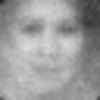

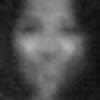

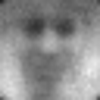

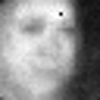

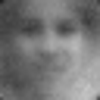

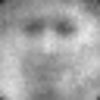

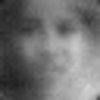

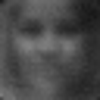

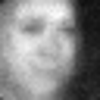

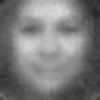

In [295]:
test_output_images = vae(testing_images[15:25])
test_output_images= [np.array(x*255, dtype=np.uint8)[:,:,0] for x in test_output_images]

for x in test_output_images:
   display(Image.fromarray(x,mode="L").resize((100,100)))

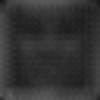

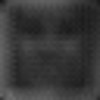

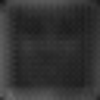

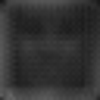

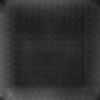

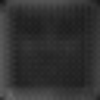

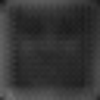

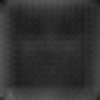

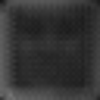

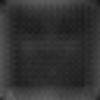

In [297]:
test_images = decoder(K.constant([np.random.rand(latent_dim) for x in range(10)]))
test_images= [np.array(x*255, dtype=np.uint8)[:,:,0] for x in test_images]

for x in test_images:
   display(Image.fromarray(x,mode="L").resize((100,100)))
